In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile("[가-힣]+")

def get_data_from_zip(zip_name):
    zip_file_path = "/content/drive/MyDrive/jolnon/" + zip_name + ".zip"
    extract_path = "/content/" + zip_name

    # zip 파일 압축 해제
    with ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + "/" + name, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    valid = []
                    for d in data["content"].split("\n"):
                        res = []
                        for word in d.split(" "):
                            if cond.match(word) != None:
                                res.append(word)
                        d = " ".join(res)
                        if d and not d.replace(" ", "").isdecimal():
                            valid.append(d)
                    result.append("\n".join([data["title"]] + valid))
        else:
            with open(extract_path + "/" + name, "r", encoding="utf-8") as f:
                data = json.load(f)
                valid = []
                for d in data["content"].split("\n"):
                    res = []
                    for word in d.split(" "):
                        if cond.match(word) != None:
                            res.append(word)
                    d = " ".join(res)
                    if d and not d.replace(" ", "").isdecimal():
                        valid.append(d)
                result.append("\n".join([data["title"]] + valid))
    return result

In [115]:
import random

random.seed(42)
galleries = ['giants_new2','cock_tail']#,'ktwiz','kartriderdrift','skwyverns_new1','ncdinos','samsunglions_new','doosanbears_new1','giants_new2','sh_new','lgtwins_new','tigers_new']
dataset = []
for e in galleries:
  dataset.append(get_data_from_zip(e))

['yskm포그다 좋아\n멋졌어',
 '정글몹 인내심 삭제기원',
 '젠지가 징동 이길 방법이 없음\n억까 거르고 차라리 더 가능성있음\n사실 여기도 가능성이 있는거지 진다고 봄\n징동 이랑 후반가면 못이김\n티원처럼 주도권잡고 초반에 밀어부쳐서 징동이 당황할때 끝내는 방법밖에 없음\n젠지는 탑 바텀이 라인전이 약한편이라 이게 안됨\n젠지가 에서 통하는게 한타를 못하는데 젠지가 한타는 좀 치는편임 근데 이 한타가 징동 하위 호환임\n징동같은팀한테 라인전 지는 순간 답없음 후반가서 이긴다는 생각버려야됨\n징동 이길 방법은 롤러 카나비 협박 밖에 없음',
 '튜토리얼 챔프 보상 안받는법 있냐?\n럭스 마이 다리 브랜드 미포\n중에 하나 고르잖아\n이거 안받는 방법있음?\n튜토리얼 안해도 레벨2되면 주던데',
 '인뚜야 럴언제함\n할깝']

In [ ]:
def remove_words(sentence, word):
    return ' '.join([w for w in sentence.split(' ') if word not in w.lower()])
stopwords = ['ㅋㅋ', 'ex', '나는', 'on', '이미지', '순서', '오늘', '일단', 'and', '이야', '그리고', '내일', '그냥', '000', '조금', '살짝', 'ㅇㅇ', 'ㅈㄱㄴ', '있음', '이거', '내가', '칵하하하', '칵하핫', '근데', '지듣노', 'youtube ', '야스중', '우흥', '한다', 'ㅎㅎ', 'ㅠㅠ', '로오오오오오옹', '하고', '아침', '것도', '추천', '혹시', '새낀데', '같다']

In [ ]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail):
    indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
    cocktail = [cocktail[i] for i in indices]
    return cocktail

In [ ]:
for k in range(len(dataset)):
    for i in range(len(dataset[k])):
        for j in range(len(stopwords)):
            dataset[k][i] = remove_words(dataset[k][i],stopwords[j])

for k in range(len(dataset)):
    dataset[k] = remove_top_n_words(dataset[k], 20)
    dataset[k] = remove_empty_sentences(dataset[k])

In [116]:
import pickle
import pandas as pd
import numpy
import re
import os
import numpy as np
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Doc2Vec

In [117]:
from gensim.models.doc2vec import TaggedDocument
train = []
label = galleries
i = 0
for category in dataset:
    for j, document in enumerate(category):
        train.append(TaggedDocument(words=document.split(), tags=[f"{label[i]}_{str(j)}"]))
    i += 1

In [118]:
LabeledSentence1 = gensim.models.doc2vec.TaggedDocument
all_content_train = []
j=0
for em in train:
    all_content_train.append(LabeledSentence1(em,[j]))
    j+=1
print('Number of texts processed: ', j)

Number of texts processed:  11230


In [119]:
d2v_model = Doc2Vec(train,vector_size = 100, window = 10, workers=7, dm = 1, alpha=0.025, min_alpha=0.001)
d2v_model.train(train, total_examples=d2v_model.corpus_count, epochs=10)


In [125]:
kmeans_model = KMeans(n_clusters=len(galleries), init='k-means++', max_iter=100, random_state=0)
X = kmeans_model.fit(d2v_model.dv.vectors)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


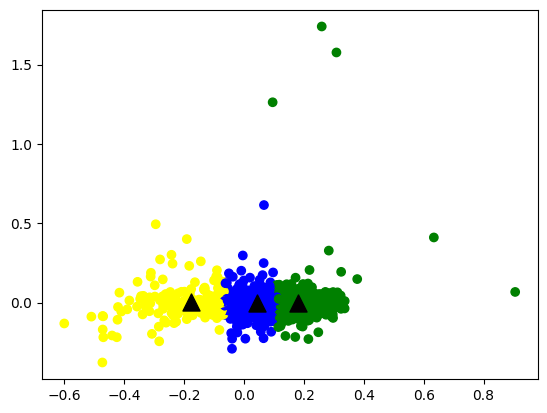

In [126]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080"]

color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [127]:
from collections import Counter
labels_count = Counter(kmeans_model.labels_)
print("\nNumber of samples in clusters:")
for cluster_num, count in labels_count.items():
    print(f"Cluster {cluster_num}: {count} samples")


Number of samples in clusters:
Cluster 0: 4390 samples
Cluster 1: 3495 samples
Cluster 2: 3345 samples


In [128]:
real_labels = []
for i in range(len(dataset[0])):
  real_labels += [i] * len(dataset[0][i])
from sklearn.metrics import confusion_matrix
print(confusion_matrix(real_labels, labels))


[[1412 1144  877]
 [1511 1073 1324]
 [1467 1278 1144]]


In [129]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def calc_purity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    _, col_ind = linear_sum_assignment(cm, maximize=True)
    reordered_cm = cm[:, col_ind]
    purity = np.sum(np.max(reordered_cm, axis=0)) / np.sum(reordered_cm)
    return purity, reordered_cm

purity, reordered_cm = calc_purity(real_labels, labels)

print("Purity: ", purity)
print("Reordered Confusion Matrix: \n", reordered_cm)

Purity:  0.3662511130899377
Reordered Confusion Matrix: 
 [[1412  877 1144]
 [1511 1324 1073]
 [1467 1144 1278]]
